In [1]:
import os
import cv2
import torch
import pandas as pd
import matplotlib.pyplot as plt

from metrics import Metric
from utils import process_depth_map

In [2]:
# model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
#model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

midas = torch.hub.load("intel-isl/MiDaS", model_type)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()

midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

Using cache found in /Users/chientm/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /Users/chientm/.cache/torch/hub/intel-isl_MiDaS_master


In [3]:
filename1 = '00019_00183_indoors_000_010.png'
filename2 = 'dog.jpg'
img1 = cv2.imread(filename1)
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.imread(filename2)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

input_batch1 = transform(img1).to(device)
input_batch2 = transform(img2).to(device)
input_batch1.shape, img1.shape, input_batch2.shape, img2.shape

(torch.Size([1, 3, 384, 512]),
 (768, 1024, 3),
 torch.Size([1, 3, 384, 480]),
 (1213, 1546, 3))

In [3]:
df = pd.read_csv('data_df.csv')
data = df[260:].reset_index(drop="true")
print(data.shape)
data.head()

(65, 3)


,image,depth,mask
0,/Users/chientm/workspace/machine-learning/dept...,/Users/chientm/workspace/machine-learning/dept...,/Users/chientm/workspace/machine-learning/dept...
1,/Users/chientm/workspace/machine-learning/dept...,/Users/chientm/workspace/machine-learning/dept...,/Users/chientm/workspace/machine-learning/dept...
2,/Users/chientm/workspace/machine-learning/dept...,/Users/chientm/workspace/machine-learning/dept...,/Users/chientm/workspace/machine-learning/dept...
3,/Users/chientm/workspace/machine-learning/dept...,/Users/chientm/workspace/machine-learning/dept...,/Users/chientm/workspace/machine-learning/dept...
4,/Users/chientm/workspace/machine-learning/dept...,/Users/chientm/workspace/machine-learning/dept...,/Users/chientm/workspace/machine-learning/dept...


In [13]:
evaluation_metrics = {'mean_absrel': [], 'mean_sqrel': [], 'rms': [], 'rms_log': [], 'delta1': [], 'delta2': [], 'delta3': []}
with torch.no_grad():
    for idx, row in data.iterrows():
        image_ = cv2.imread(row['image'])
        image_ = cv2.cvtColor(image_, cv2.COLOR_BGR2RGB)
        input_image = transform(image_).to(device)
        h, w = input_image.shape[-2:]

        depth_map = process_depth_map(row['depth'], row['mask'], (w,h))
        
        pred = midas(input_image)
        pred_np = pred.permute(1, 2, 0).numpy()
        
        metric = Metric(depth_map, pred_np)
        evaluation_metrics['mean_absrel'].append(metric.mean_absrel_err())
        evaluation_metrics['mean_sqrel'].append(metric.mean_sqrel_err())
        evaluation_metrics['rms'].append(metric.rms_err())
        evaluation_metrics['rms_log'].append(metric.rms_log_err())
        evaluation_metrics['delta1'].append(metric.percentage_of_pixel_acc()['delta1'])
        evaluation_metrics['delta2'].append(metric.percentage_of_pixel_acc()['delta2'])
        evaluation_metrics['delta3'].append(metric.percentage_of_pixel_acc()['delta3'])

/Users/chientm/workspace/machine-learning/depth_estimation/metrics.py:37: RuntimeWarning: divide by zero encountered in true_divide
  thresh = np.maximum((self.y_pred/self.y_true), (self.y_true/self.y_pred))


In [14]:
res_df = pd.DataFrame(evaluation_metrics)
res_df.mean()

mean_absrel    3.280177e+03
mean_sqrel     6.632384e+06
rms            1.304013e+03
rms_log        7.307578e+00
delta1         7.856320e-05
delta2         1.586132e-04
delta3         2.595559e-04
dtype: float64

In [4]:
imgs, depth_gts, depth_preds = [], [], []
with torch.no_grad():
    for idx, row in data.iterrows():
        if idx >= 4:
            break
        image_ = cv2.imread(row['image'])
        image_ = cv2.cvtColor(image_, cv2.COLOR_BGR2RGB)
        input_image = transform(image_).to(device)
        h, w = input_image.shape[-2:]

        depth_map = process_depth_map(row['depth'], row['mask'], (w,h))
        
        pred = midas(input_image)
        pred_np = pred.permute(1, 2, 0).numpy()
        
        imgs.append(image_)
        depth_gts.append(depth_map)
        depth_preds.append(pred_np)

/Users/chientm/miniconda3/envs/sandbox/lib/python3.9/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


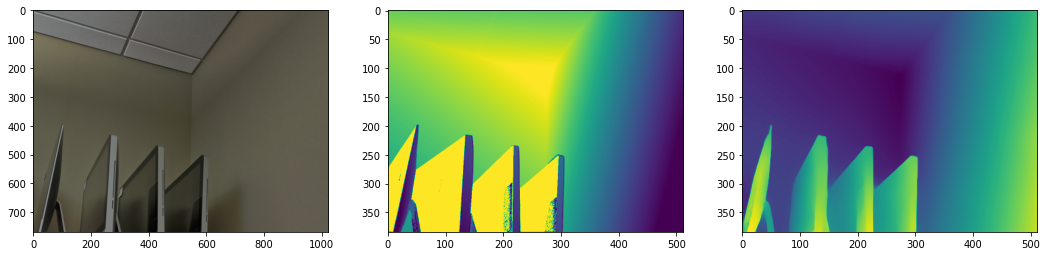

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(18, 18))

i = 0
ax[0].imshow(imgs[i])
ax[1].imshow(depth_gts[i])
ax[2].imshow(depth_preds[i])

In [19]:
depth_gts[i][:, :, 0]

array([[0.64646465, 0.64554745, 0.64417189, ..., 0.19648997, 0.1942611 ,
        0.19249266],
       [0.64842713, 0.64827871, 0.64798254, ..., 0.19613048, 0.19393465,
        0.19207984],
       [0.65013671, 0.65015566, 0.65013927, ..., 0.1957342 , 0.19350946,
        0.19159067],
       ...,
       [0.63656843, 0.81001747, 0.81001747, ..., 0.1       , 0.1       ,
        0.1       ],
       [0.63630801, 0.81001747, 0.81001747, ..., 0.1       , 0.1       ,
        0.1       ],
       [0.4624998 , 0.46259296, 0.4632315 , ..., 0.1       , 0.1       ,
        0.1       ]])

In [21]:
tmp[:, :, 0]

array([[0.21141979, 0.20990634, 0.21070746, ..., 0.58060396, 0.57911086,
        0.47684008],
       [0.20713659, 0.2097896 , 0.2103931 , ..., 0.5806549 , 0.57755727,
        0.58165663],
       [0.21001486, 0.2095982 , 0.20965709, ..., 0.5815324 , 0.58298945,
        0.5842603 ],
       ...,
       [0.46709892, 0.50298244, 0.5374446 , ..., 0.74611247, 0.74667567,
        0.74906045],
       [0.4763966 , 0.511342  , 0.5421846 , ..., 0.7450282 , 0.7483882 ,
        0.74694735],
       [0.49470186, 0.5200285 , 0.54654264, ..., 0.74803436, 0.7473924 ,
        0.7451625 ]], dtype=float32)

In [13]:
depth_gts[i].min(), depth_gts[i].max(), depth_preds[i].min(), depth_preds[i].max()

(0.10000000149011612, 0.810017466545105, 67.03899, 1977.3997)

In [14]:
def general_normalize(data, origin_range, target_range):
    ori_min, ori_max = origin_range
    tar_min, tar_max = target_range
    return tar_min + (data - ori_min) * ((tar_max - tar_min) / (ori_max - ori_min))

In [17]:
tmp = general_normalize(depth_preds[i], (depth_preds[i].min(), depth_preds[i].max()), (depth_gts[i].min(), depth_gts[i].max()))

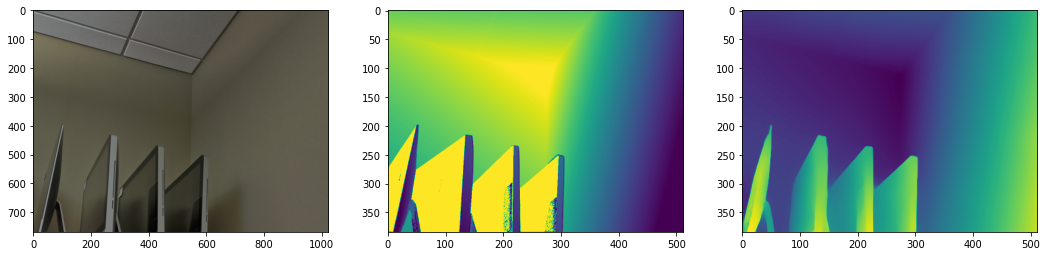

In [18]:
fig, ax = plt.subplots(1, 3, figsize=(18, 18))

i = 0
ax[0].imshow(imgs[i])
ax[1].imshow(depth_gts[i])
ax[2].imshow(tmp)